https://docs.fast.ai/text.html

In [111]:
from fastai import *
from fastai.text import *

In [112]:
import fastai; fastai.__version__

'1.0.22'

In [113]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
path = Path('/data/quora-insincere-questions-classification')

In [218]:
df0 = pd.read_csv(path/'train.csv')

In [219]:
# df = df0.sample(50000)

df = df0.copy()

In [220]:
df.shape

(1306122, 3)

In [221]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## prepare data for fastai

In [222]:
df.drop(columns=['qid'], inplace=True)

df['target'] = df.target.astype(int)

df = df[['target', 'question_text']]

df.columns = ['label', 'text']

In [223]:
df.head()

,label,text
0,0,How did Quebec nationalists see their province...
1,0,"Do you have an adopted dog, how would you enco..."
2,0,Why does velocity affect time? Does velocity a...
3,0,How did Otto von Guericke used the Magdeburg h...
4,0,Can I convert montra helicon D to a mountain b...


In [224]:
print("\n\n".join(df[df.label==1].text.sample(5).values))

Would it be equivalent in saying that liberal vs conservative is the same as good vs evil (or vice versa)?

Should canadians take back thier lands from British policeing?

What is the reason, Kashmiris are more attracted towards Pakistan inspite that India is far better option to be with?

Who breaks more hearts, woman or men?

Is Indian really as bad as people used to think?


In [225]:
print(f"{df.label.mean()*100:.2f}% questions are insincere.")

6.19% questions are insincere.


In [226]:
df.to_csv(path/f"fastai_train.csv", index=False)

To get a DataBunch quickly, there are also several factory methods depending on how our data is structured. They are all detailed in text.data, here we'll use the method from_csv of the TextLMDataBunch (to get the data ready for a language model) and TextClasDataBunch (to get the data ready for a text classifier) classes.

In [227]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, path/f"fastai_train.csv")
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, path/f"fastai_train.csv", vocab=data_lm.train_ds.vocab, bs=32)

In [228]:
data_lm.save()
data_clas.save()

In [229]:
data_lm = TextLMDataBunch.load(path)
data_clas = TextClasDataBunch.load(path, bs=32)
# Note that you can load the data with different DataBunch parameters (batch size, bptt,...)

In [230]:
# Fine-tuning a language model
# We can use the data_lm object we created earlier to fine-tune a pretrained language model. fast.ai has an English model available that we can download. We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning.

learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.5)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


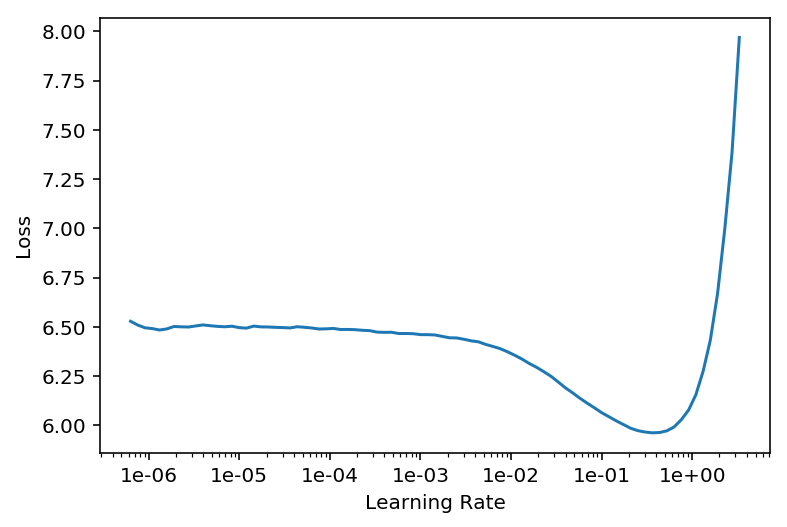

In [231]:
learn.lr_find()

learn.recorder.plot()

In [232]:
learn.fit_one_cycle(1, 1e-3)

Total time: 09:58
epoch  train_loss  valid_loss  accuracy
1      4.316950    4.069096    0.347642  (09:58)



In [233]:
# Like a computer vision model, we can then unfreeze the model and fine-tune it.

learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

Total time: 11:10
epoch  train_loss  valid_loss  accuracy
1      3.760032    3.624386    0.388620  (11:10)



In [234]:
# And finally we save the encoder to be able to use it for classification in the next section.

learn.save_encoder('ft_enc')
# Building a classifier
# We now use the data_clas object we created earlier to build a classifier with our fine-tuned encoder. The learner object can be done in a single line.

In [235]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('ft_enc')

In [236]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


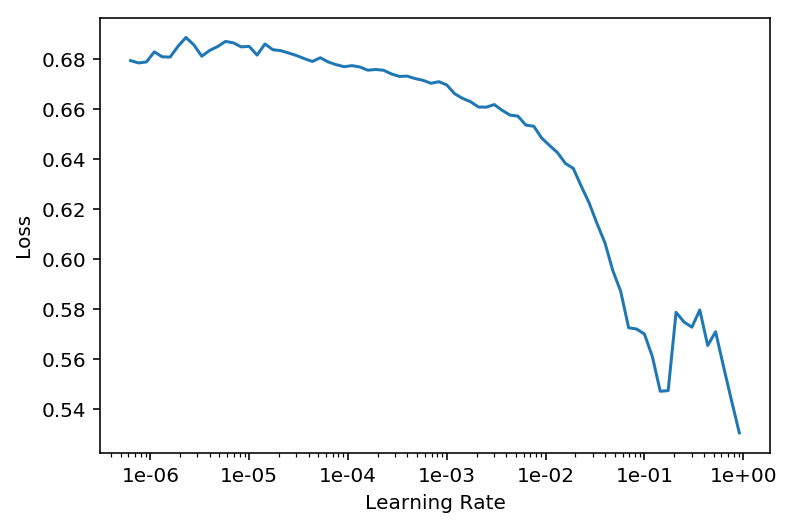

In [237]:
learn.recorder.plot()

In [238]:
learn.fit_one_cycle(1, 1e-4)

Total time: 10:22
epoch  train_loss  valid_loss  accuracy
1      0.138309    0.126704    0.950150  (10:22)



In [239]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-7/2., 5e-7))

Total time: 13:05
epoch  train_loss  valid_loss  accuracy
1      0.139172    0.125068    0.951387  (13:05)



In [240]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-7/100, 2e-7))

Total time: 29:04
epoch  train_loss  valid_loss  accuracy
1      0.147102    0.125368    0.950885  (29:04)



In [263]:
learn.save(path/'fastai-20181112')

In [242]:
preds,y=learn.get_preds()

In [243]:
preds[:3]

tensor([[9.9990e-01, 9.8090e-05],
        [9.9999e-01, 8.0760e-06],
        [9.9997e-01, 3.3706e-05]])

In [244]:
y.float().mean(), preds[:, 1].mean(0)

(tensor(0.0621), tensor(0.0614))

In [245]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [246]:
accuracy_score(y, preds[:, 1]>0.5)

0.9508852521772418

In [247]:
f1_score(y, preds[:, 1]>0.5)

0.48023010857235465

In [248]:
f1_score(y, preds[:, 1]>0.2)

0.5780974898133708

In [258]:
threshes = np.linspace(0, 0.5, num=11)
f1s = []
for thresh in threshes:
    f1s.append(f1_score(y, preds[:, 1]>thresh))

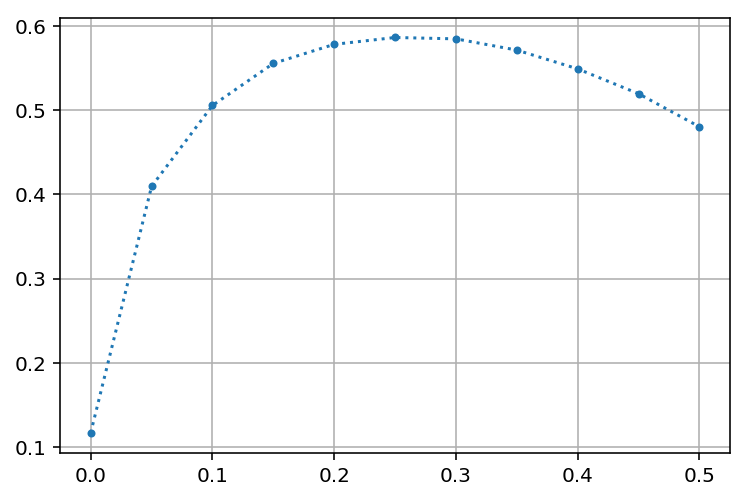

In [262]:
plt.plot(threshes, f1s, '.:')
plt.grid()